# Data loading and model training with BERT vectors

In [21]:
import os
import json
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [2]:
ORIGINAL_DATA_DIR = os.path.join("..", "handout", "data")
BERT_FEATURE_DIR = "bert_output_data"

## Formatting data

`X` will be a matrix with `N` rows for the `N` texts in the training data, and `M` columns for the `M` features generated by BERT.

`y` will be an array of `N` class labels for training.

### Training data

In [3]:
train_df = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, "lang_id_train.csv"))

In [4]:
train_df.shape

(6000, 2)

In [5]:
bert_train_vectors = []
with open(os.path.join(BERT_FEATURE_DIR, "train.jsonlines"), "rt") as infile:
    for line in infile:
        bert_data = json.loads(line)
        for t in bert_data["features"]:
            # Only extract the [CLS] vector used for classification
            if t["token"] == "[CLS]":
                # We only use the representation at the final layer of the network
                bert_train_vectors.append(t["layers"][0]["values"])
                break

In [6]:
len(bert_train_vectors)

6000

In [7]:
X_train = np.array(bert_train_vectors)
y_train = train_df["native_language"].values

### Testing data

In [8]:
test_df = pd.read_csv(os.path.join(ORIGINAL_DATA_DIR, "lang_id_test.csv"))

In [9]:
test_df.shape

(2000, 2)

In [10]:
bert_test_vectors = []
with open(os.path.join(BERT_FEATURE_DIR, "test.jsonlines"), "rt") as infile:
    for line in infile:
        bert_data = json.loads(line)
        for t in bert_data["features"]:
            # Only extract the [CLS] vector used for classification
            if t["token"] == "[CLS]":
                # We only use the representation at the final layer of the network
                bert_test_vectors.append(t["layers"][0]["values"])
                break

In [11]:
len(bert_test_vectors)

2000

In [12]:
X_test = np.array(bert_test_vectors)
y_test = test_df["native_language"].values

## Logistic regression model

### Train LR model

In [13]:
lr_model = LogisticRegression(penalty="l2", C=1.0)
lr_model = lr_model.fit(X_train, y_train)
train_score_lr_model = lr_model.score(X_train, y_train)
train_score_lr_model

C:\Users\yashm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\yashm\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.7348333333333333

### Test LR model

In [14]:
y_pred_lr_model = lr_model.predict(X_test)
y_pred_lr_model

array(['Mandarin', 'Arabic', 'Mandarin', ..., 'Korean', 'Arabic',
       'Arabic'], dtype=object)

### Evaluate LR model

In [15]:
test_score_lr_model = lr_model.score(X_test,y_test)
test_score_lr_model

0.466

Text(60.0, 0.5, 'True Label')

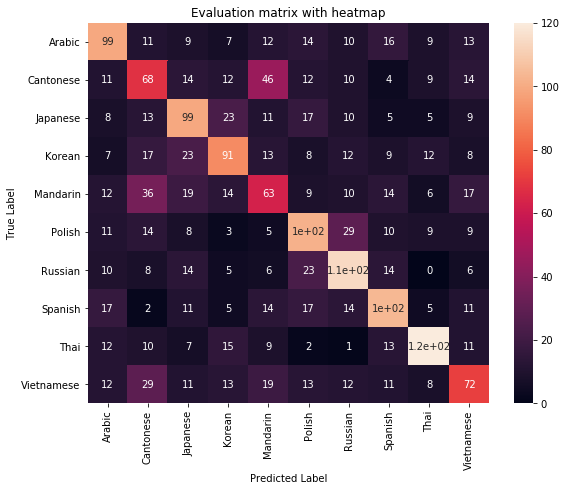

In [16]:
confusion_matrix_lr_model = confusion_matrix(y_test, y_pred_lr_model)
df_con_mat_lr_model = pd.DataFrame(confusion_matrix_lr_model, index=lr_model.classes_, columns=lr_model.classes_)

plt.figure(figsize = (9,7))
sns.heatmap(df_con_mat_lr_model, annot = True)
plt.title('Evaluation matrix with heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [17]:
misclassification_rate_test_each_class_lr_model = []

for lan in lr_model.classes_:
    FP = sum(df_con_mat_lr_model.iloc[lr_model.classes_.tolist().index(lan)]) - df_con_mat_lr_model[lan][lan]
    FN = sum(df_con_mat_lr_model[lan]) - df_con_mat_lr_model[lan][lan]
    misclassification_rate = ((FP + FN) / y_pred_lr_model.shape[0]) * 100
    misclassification_rate_test_each_class_lr_model.append(misclassification_rate)

precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred_lr_model)
result_each_class = pd.DataFrame(columns=['language', 'misclassification', 'precision', 'recall', 'f1 score', 'support'])
for lan in range(len(lr_model.classes_)):
    result_each_class = result_each_class.append(pd.DataFrame([[lr_model.classes_[lan], misclassification_rate_test_each_class_lr_model[lan], precision[lan], recall[lan], f1score[lan], support[lan]]], columns=['language', 'misclassification', 'precision', 'recall', 'f1 score', "support"]))
result_each_class.index = list(range(0,result_each_class.shape[0]))
print(result_each_class.to_string())

     language  misclassification  precision  recall  f1 score support
0      Arabic              10.05   0.497487   0.495  0.496241     200
1   Cantonese              13.60   0.326923   0.340  0.333333     200
2    Japanese              10.85   0.460465   0.495  0.477108     200
3      Korean              10.30   0.484043   0.455  0.469072     200
4    Mandarin              13.60   0.318182   0.315  0.316583     200
5      Polish              10.65   0.470046   0.510  0.489209     200
6     Russian               9.70   0.513514   0.570  0.540284     200
7     Spanish               9.60   0.520000   0.520  0.520000     200
8        Thai               7.15   0.655738   0.600  0.626632     200
9  Vietnamese              11.30   0.423529   0.360  0.389189     200


In [18]:
result_pair_class = pd.DataFrame(columns=['True Label', 'Predicted Label', 'Misclassification'])
for true in lr_model.classes_:
    for predicted in lr_model.classes_:
        if(true != predicted):
            result_pair_class = result_pair_class.append(pd.DataFrame([[true, predicted, df_con_mat_lr_model[true][predicted]]], columns=['True Label', 'Predicted Label', 'Misclassification']))
result_pair_class.index = list(range(0,result_pair_class.shape[0]))
print(result_pair_class.to_string())

    True Label Predicted Label Misclassification
0       Arabic       Cantonese                11
1       Arabic        Japanese                 8
2       Arabic          Korean                 7
3       Arabic        Mandarin                12
4       Arabic          Polish                11
5       Arabic         Russian                10
6       Arabic         Spanish                17
7       Arabic            Thai                12
8       Arabic      Vietnamese                12
9    Cantonese          Arabic                11
10   Cantonese        Japanese                13
11   Cantonese          Korean                17
12   Cantonese        Mandarin                36
13   Cantonese          Polish                14
14   Cantonese         Russian                 8
15   Cantonese         Spanish                 2
16   Cantonese            Thai                10
17   Cantonese      Vietnamese                29
18    Japanese          Arabic                 9
19    Japanese      

## Decision Tree model

### Train DT model

In [22]:
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
train_score_dt_model = dt_model.score(X_train, y_train)
train_score_dt_model

1.0

### Test DT model

In [23]:
y_pred_dt_model = dt_model.predict(X_test)
y_pred_dt_model

array(['Thai', 'Polish', 'Japanese', ..., 'Cantonese', 'Russian',
       'Mandarin'], dtype=object)

### Evaluate DT model

In [24]:
test_score_dt_model = dt_model.score(X_test,y_test)
test_score_dt_model

0.1755

Text(60.0, 0.5, 'True Label')

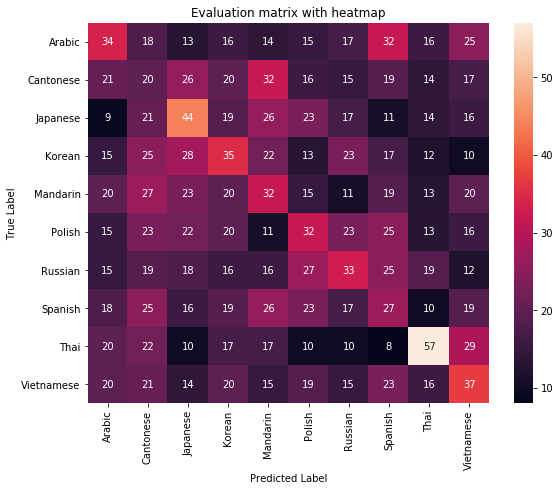

In [25]:
confusion_matrix_dt_model = confusion_matrix(y_test, y_pred_dt_model)
df_con_mat_dt_model = pd.DataFrame(confusion_matrix_dt_model, index=dt_model.classes_, columns=dt_model.classes_)

plt.figure(figsize = (9,7))
sns.heatmap(df_con_mat_dt_model, annot = True)
plt.title('Evaluation matrix with heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [26]:
misclassification_rate_test_each_class_dt_model = []

for lan in dt_model.classes_:
    FP = sum(df_con_mat_dt_model.iloc[dt_model.classes_.tolist().index(lan)]) - df_con_mat_dt_model[lan][lan]
    FN = sum(df_con_mat_dt_model[lan]) - df_con_mat_dt_model[lan][lan]
    misclassification_rate = ((FP + FN) / y_pred_dt_model.shape[0]) * 100
    misclassification_rate_test_each_class_dt_model.append(misclassification_rate)

precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred_dt_model)
result_each_class = pd.DataFrame(columns=['language', 'misclassification', 'precision', 'recall', 'f1 score', 'support'])
for lan in range(len(dt_model.classes_)):
    result_each_class = result_each_class.append(pd.DataFrame([[dt_model.classes_[lan], misclassification_rate_test_each_class_dt_model[lan], precision[lan], recall[lan], f1score[lan], support[lan]]], columns=['language', 'misclassification', 'precision', 'recall', 'f1 score', "support"]))
result_each_class.index = list(range(0,result_each_class.shape[0]))
print(result_each_class.to_string())

     language  misclassification  precision  recall  f1 score support
0      Arabic              15.95   0.181818   0.170  0.175711     200
1   Cantonese              19.05   0.090498   0.100  0.095012     200
2    Japanese              16.30   0.205607   0.220  0.212560     200
3      Korean              16.60   0.173267   0.175  0.174129     200
4    Mandarin              17.35   0.151659   0.160  0.155718     200
5      Polish              16.45   0.165803   0.160  0.162850     200
6     Russian              15.75   0.182320   0.165  0.173228     200
7     Spanish              17.60   0.131068   0.135  0.133005     200
8        Thai              13.50   0.309783   0.285  0.296875     200
9  Vietnamese              16.35   0.184080   0.185  0.184539     200


In [27]:
result_pair_class = pd.DataFrame(columns=['True Label', 'Predicted Label', 'Misclassification'])
for true in dt_model.classes_:
    for predicted in dt_model.classes_:
        if(true != predicted):
            result_pair_class = result_pair_class.append(pd.DataFrame([[true, predicted, df_con_mat_dt_model[true][predicted]]], columns=['True Label', 'Predicted Label', 'Misclassification']))
result_pair_class.index = list(range(0,result_pair_class.shape[0]))
print(result_pair_class.to_string())

    True Label Predicted Label Misclassification
0       Arabic       Cantonese                21
1       Arabic        Japanese                 9
2       Arabic          Korean                15
3       Arabic        Mandarin                20
4       Arabic          Polish                15
5       Arabic         Russian                15
6       Arabic         Spanish                18
7       Arabic            Thai                20
8       Arabic      Vietnamese                20
9    Cantonese          Arabic                18
10   Cantonese        Japanese                21
11   Cantonese          Korean                25
12   Cantonese        Mandarin                27
13   Cantonese          Polish                23
14   Cantonese         Russian                19
15   Cantonese         Spanish                25
16   Cantonese            Thai                22
17   Cantonese      Vietnamese                21
18    Japanese          Arabic                13
19    Japanese      

## Support Vector model

### Train SVM model

In [28]:
svm_model = LinearSVC()
svm_model = svm_model.fit(X_train, y_train)
train_score_svm_model = svm_model.score(X_train, y_train)
train_score_svm_model

C:\Users\yashm\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.7658333333333334

### Test SVM model

In [29]:
y_pred_svm_model = svm_model.predict(X_test)
y_pred_svm_model

array(['Mandarin', 'Arabic', 'Korean', ..., 'Korean', 'Cantonese',
       'Arabic'], dtype=object)

### Evaluate SVM model

In [30]:
test_score_svm_model = svm_model.score(X_test,y_test)
test_score_svm_model

0.426

Text(60.0, 0.5, 'True Label')

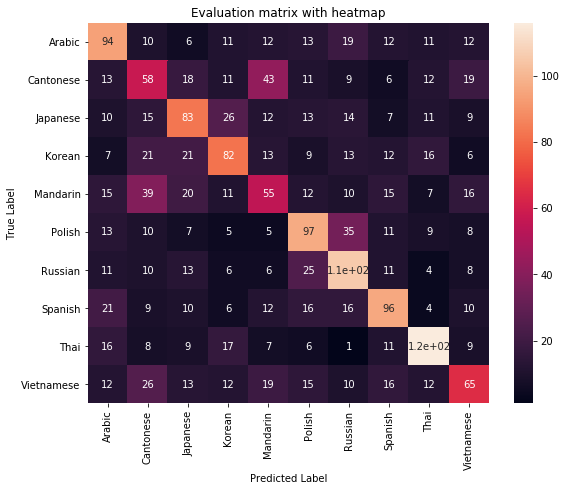

In [31]:
confusion_matrix_svm_model = confusion_matrix(y_test, y_pred_svm_model)
df_con_mat_svm_model = pd.DataFrame(confusion_matrix_svm_model, index=svm_model.classes_, columns=svm_model.classes_)

plt.figure(figsize = (9,7))
sns.heatmap(df_con_mat_svm_model, annot = True)
plt.title('Evaluation matrix with heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [32]:
misclassification_rate_test_each_class_svm_model = []

for lan in svm_model.classes_:
    FP = sum(df_con_mat_svm_model.iloc[svm_model.classes_.tolist().index(lan)]) - df_con_mat_svm_model[lan][lan]
    FN = sum(df_con_mat_svm_model[lan]) - df_con_mat_svm_model[lan][lan]
    misclassification_rate = ((FP + FN) / y_pred_svm_model.shape[0]) * 100
    misclassification_rate_test_each_class_svm_model.append(misclassification_rate)

precision, recall, f1score, support = precision_recall_fscore_support(y_test, y_pred_svm_model)
result_each_class = pd.DataFrame(columns=['language', 'misclassification', 'precision', 'recall', 'f1 score', 'support'])
for lan in range(len(svm_model.classes_)):
    result_each_class = result_each_class.append(pd.DataFrame([[svm_model.classes_[lan], misclassification_rate_test_each_class_svm_model[lan], precision[lan], recall[lan], f1score[lan], support[lan]]], columns=['language', 'misclassification', 'precision', 'recall', 'f1 score', "support"]))
result_each_class.index = list(range(0,result_each_class.shape[0]))
print(result_each_class.to_string())

     language  misclassification  precision  recall  f1 score support
0      Arabic              11.20   0.443396   0.470  0.456311     200
1   Cantonese              14.50   0.281553   0.290  0.285714     200
2    Japanese              11.70   0.415000   0.415  0.415000     200
3      Korean              11.15   0.438503   0.410  0.423773     200
4    Mandarin              13.70   0.298913   0.275  0.286458     200
5      Polish              11.15   0.447005   0.485  0.465228     200
6     Russian              11.05   0.454936   0.530  0.489607     200
7     Spanish              10.25   0.487310   0.480  0.483627     200
8        Thai               8.50   0.574257   0.580  0.577114     200
9  Vietnamese              11.60   0.401235   0.325  0.359116     200


In [33]:
result_pair_class = pd.DataFrame(columns=['True Label', 'Predicted Label', 'Misclassification'])
for true in svm_model.classes_:
    for predicted in svm_model.classes_:
        if(true != predicted):
            result_pair_class = result_pair_class.append(pd.DataFrame([[true, predicted, df_con_mat_svm_model[true][predicted]]], columns=['True Label', 'Predicted Label', 'Misclassification']))
result_pair_class.index = list(range(0,result_pair_class.shape[0]))
print(result_pair_class.to_string())

    True Label Predicted Label Misclassification
0       Arabic       Cantonese                13
1       Arabic        Japanese                10
2       Arabic          Korean                 7
3       Arabic        Mandarin                15
4       Arabic          Polish                13
5       Arabic         Russian                11
6       Arabic         Spanish                21
7       Arabic            Thai                16
8       Arabic      Vietnamese                12
9    Cantonese          Arabic                10
10   Cantonese        Japanese                15
11   Cantonese          Korean                21
12   Cantonese        Mandarin                39
13   Cantonese          Polish                10
14   Cantonese         Russian                10
15   Cantonese         Spanish                 9
16   Cantonese            Thai                 8
17   Cantonese      Vietnamese                26
18    Japanese          Arabic                 6
19    Japanese      